In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
import warnings

from data_preparation_tools import preprocessing_data
from cv_wrappers_and_tools import cv_xgb, plot_roc_auc, make_prediction_xgb, save_model_and_results

warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity = 0)

/home/michail/soft/anaconda3/envs/SuspiciousNetworkEventRecognition/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# XGBoost

## Grid search

In [6]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)
print(df_train.shape)
print(df_test.shape)

(39427, 62)
(20000, 61)


In [7]:
# Select features, that won't be used to create predictive models
feature_black_list = ['grandparent_category']
feature_grey_list = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'score']

# Select target variable
target = 'notified'
# Prepare  training and test datasets for modeling
preprocessed_train_df, preprocessed_test_df, _, features = preprocessing_data(df_train, df_test, target, feature_black_list)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdax 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2022, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 31541
Length valid: 7886
[0]	train-auc:0.82135	valid-auc:0.80238
[1]	train-auc:0.84872	valid-auc:0.82607
[2]	train-auc:0.85297	valid-auc:0.83001
[3]	train-auc:0.85962	valid-auc:0.83622
[4]	train-auc:0.86361	valid-auc:0.83631
[5]	train-auc:0.87063	valid-auc:0.83957
[6]	train-auc:0.87216	valid-auc:0.83796
[7]	train-auc:0.87560	valid-auc:0.83994
[8]	train-auc:0.88028	valid-auc:0.84420
[9]	train-auc:0.88335	valid-auc:0.84719
[10]	train-auc:0.88824	valid-auc:0.85304
[11]	train-auc:0.89091	valid-auc:0.85738
[12]	train-auc:0.89510	valid-auc:0.86044
[13]	train-auc:0.89858	valid-auc:0.86479
[14]	train-auc:0.89876	valid-auc:0.86421
[15]	train-auc:0.89945	valid-a

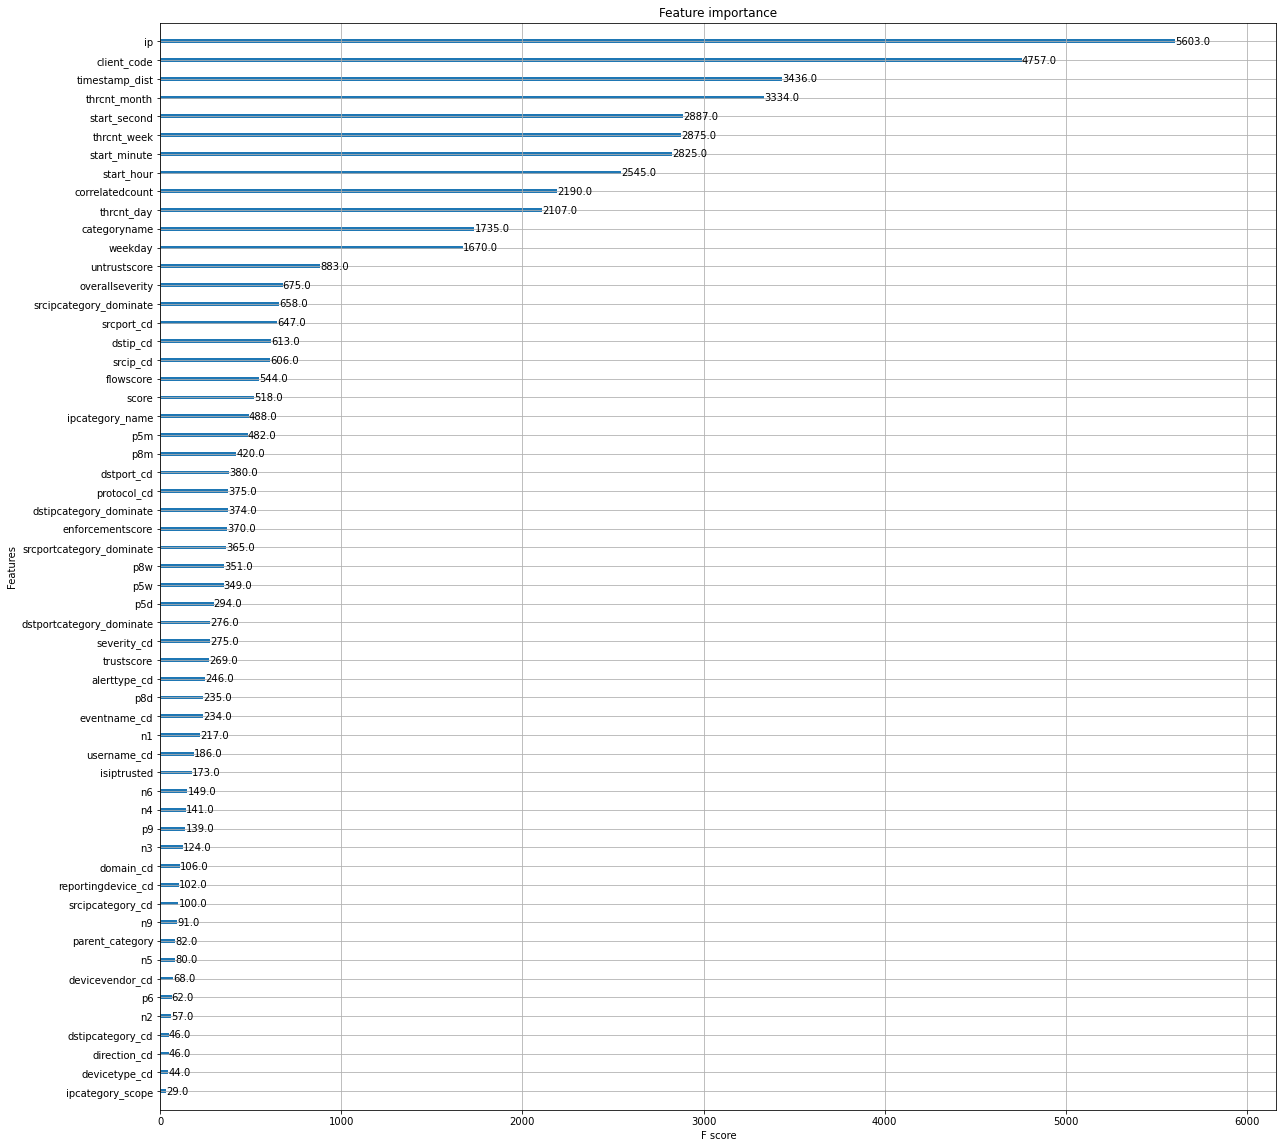

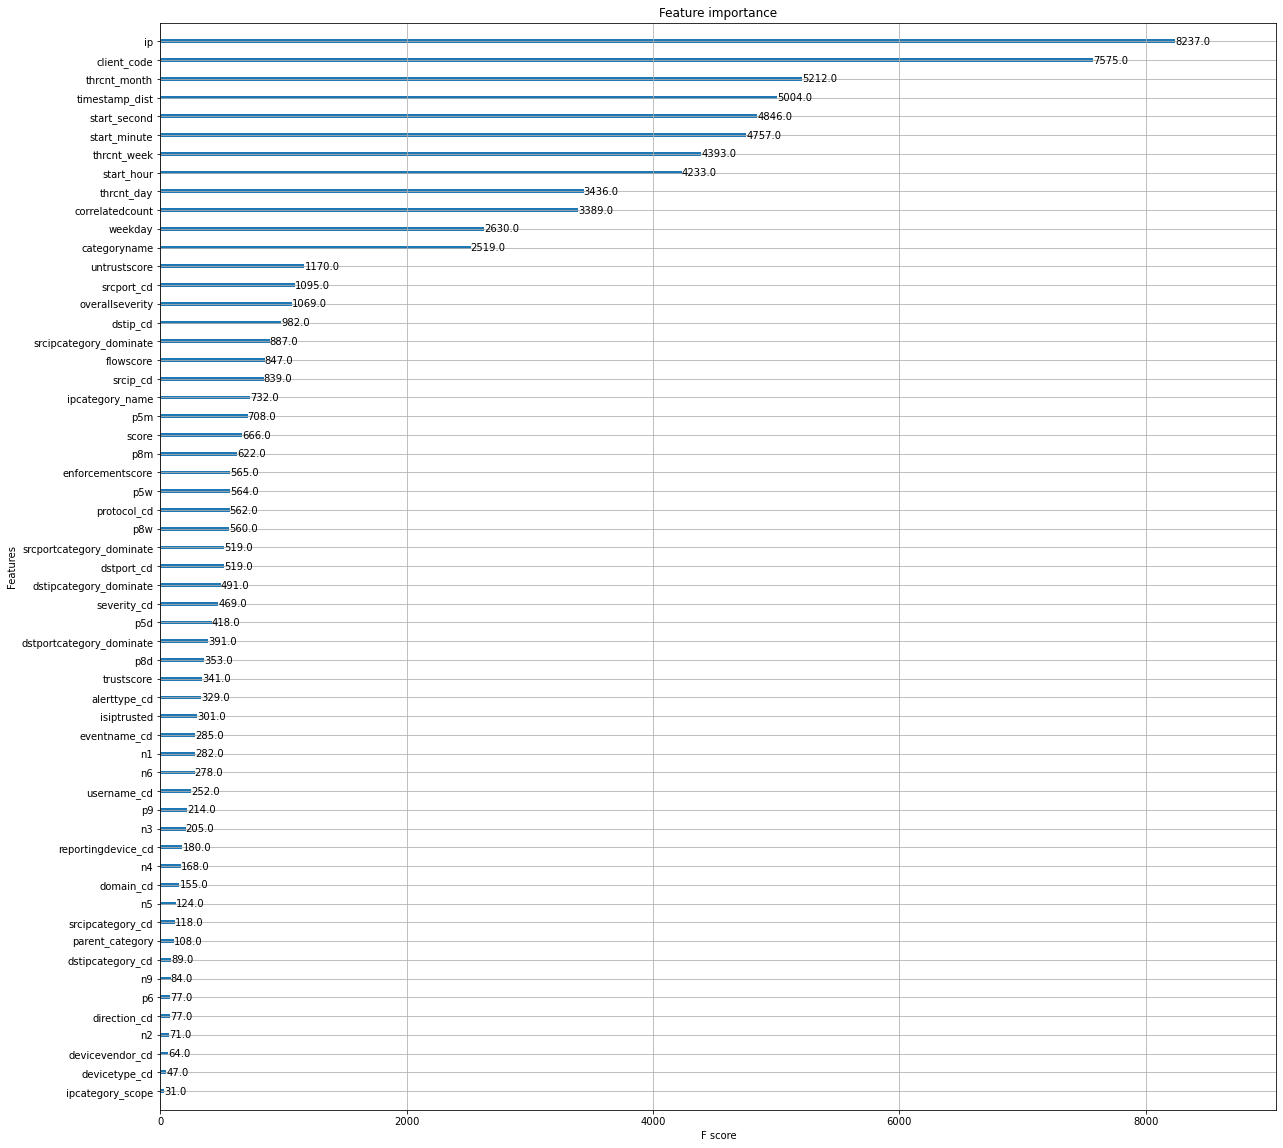

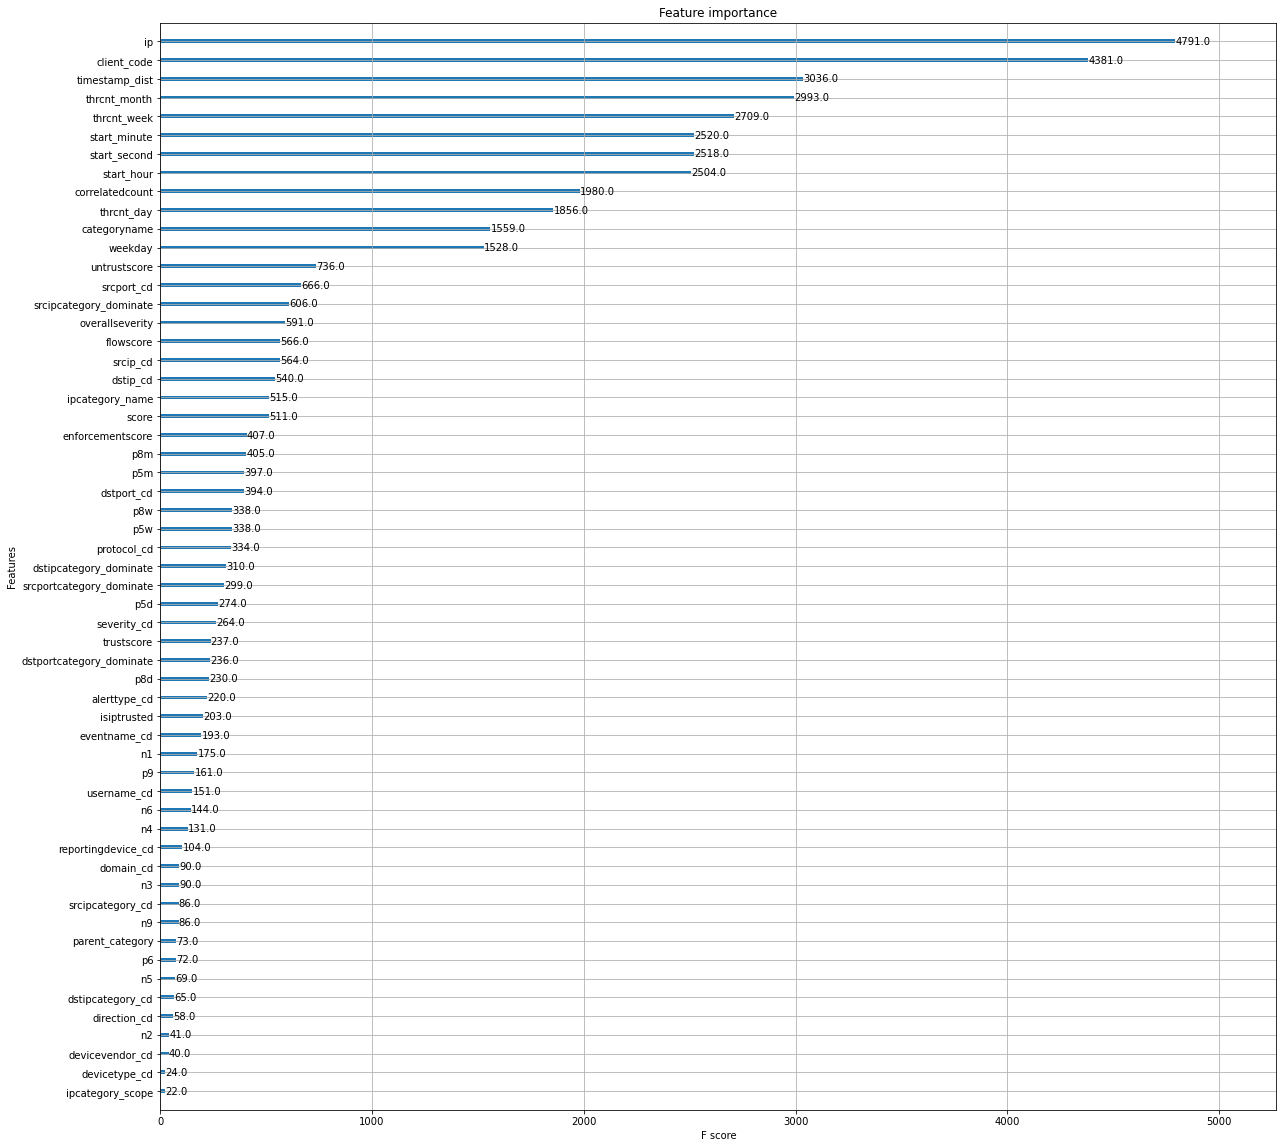

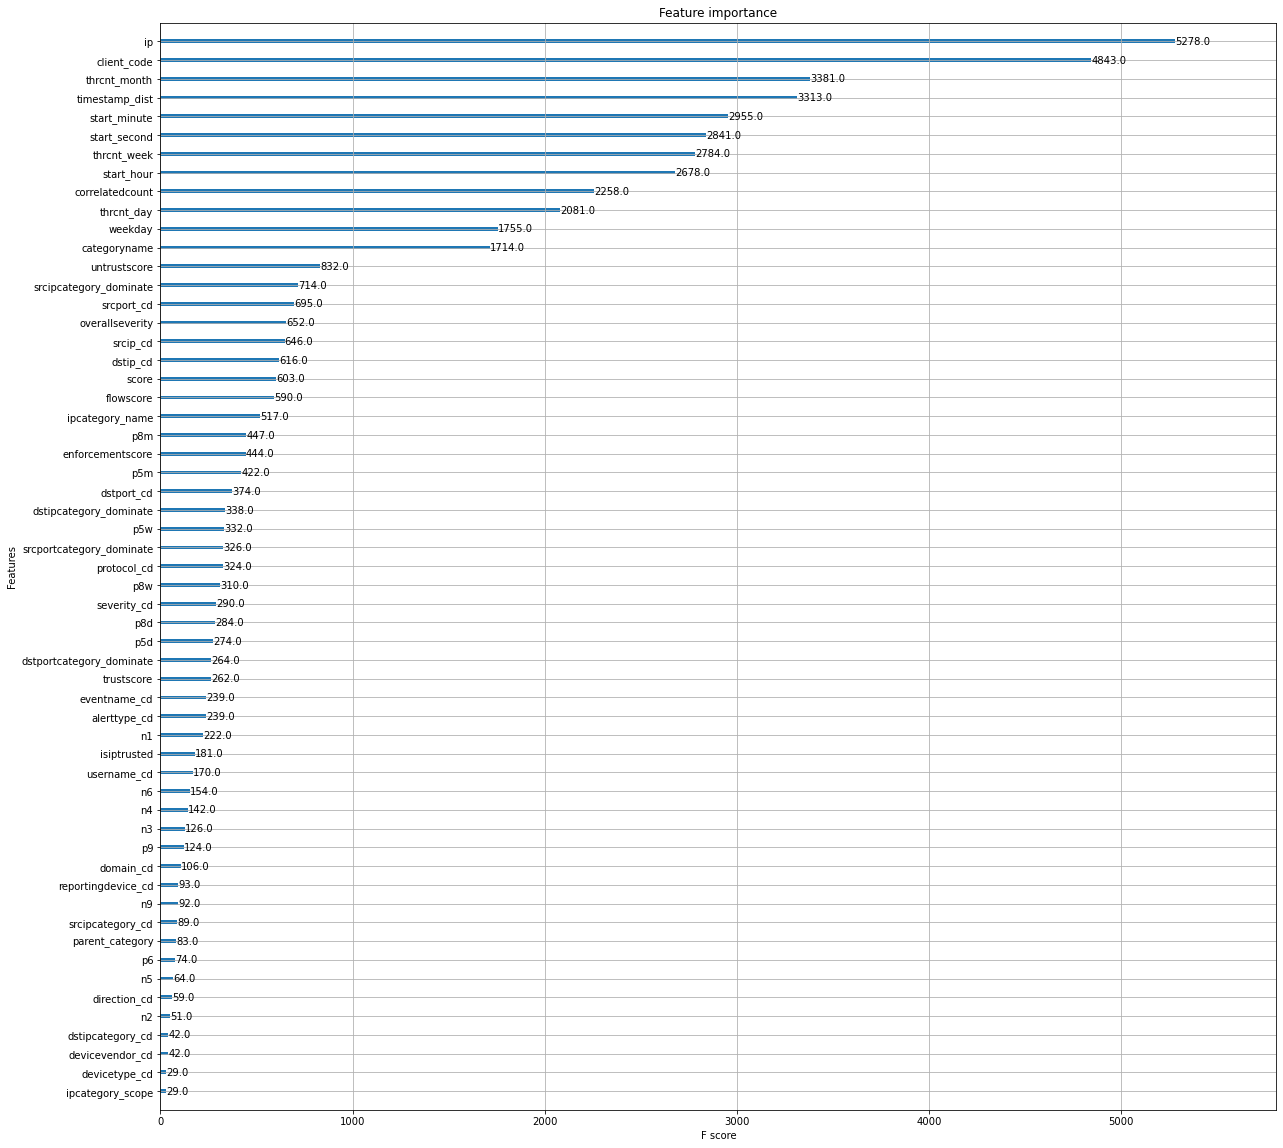

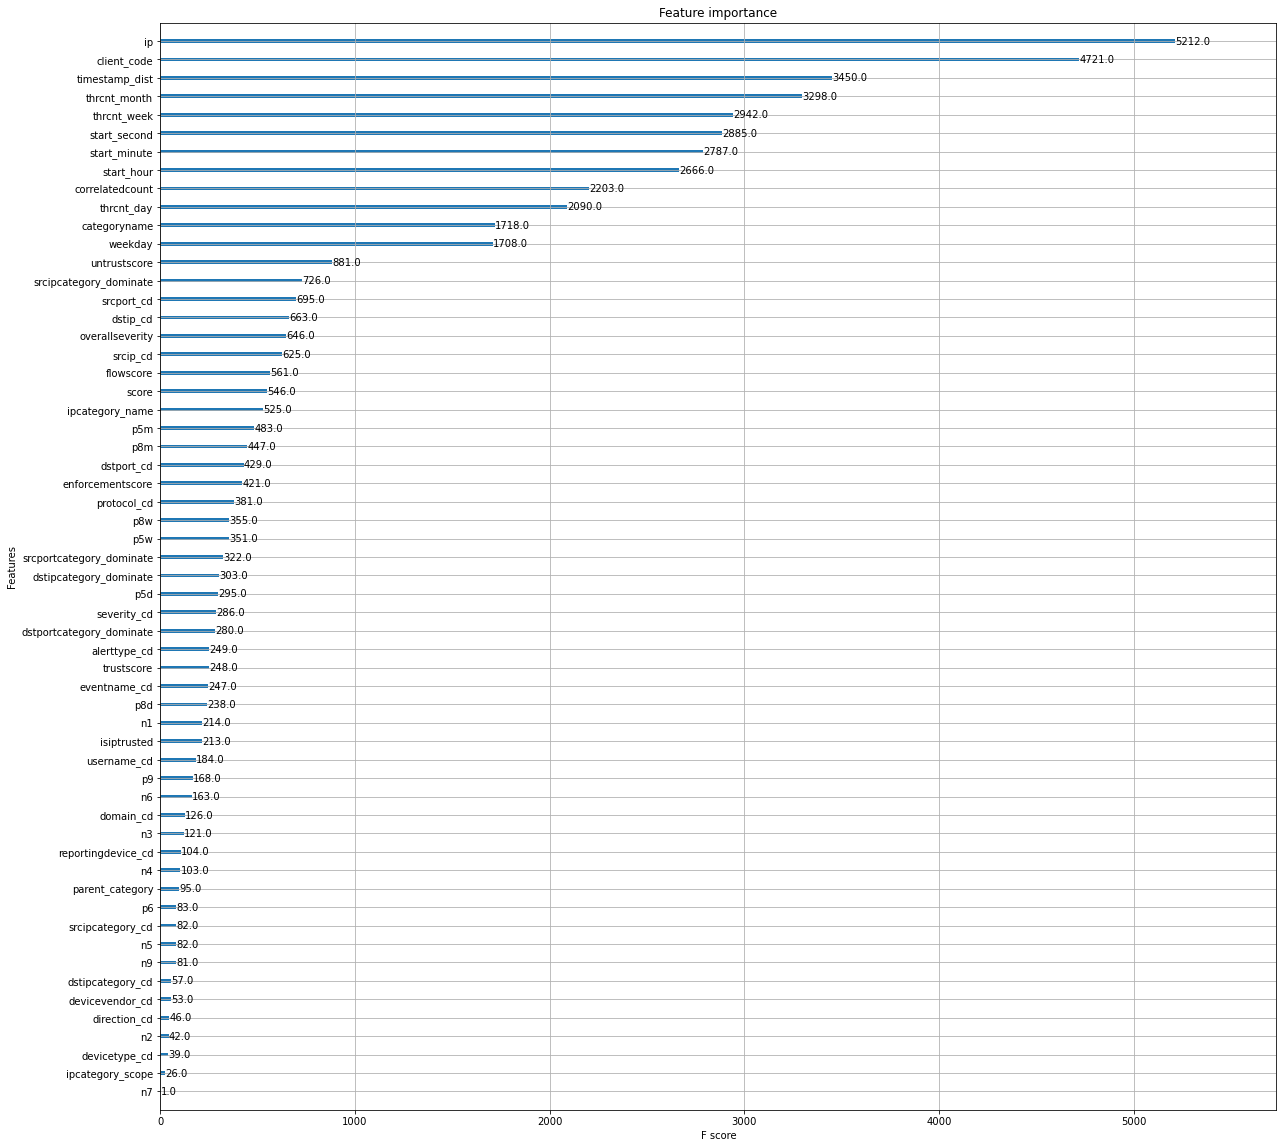

In [7]:
trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=True, mlflow_tracking=True)
print(f'Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}')

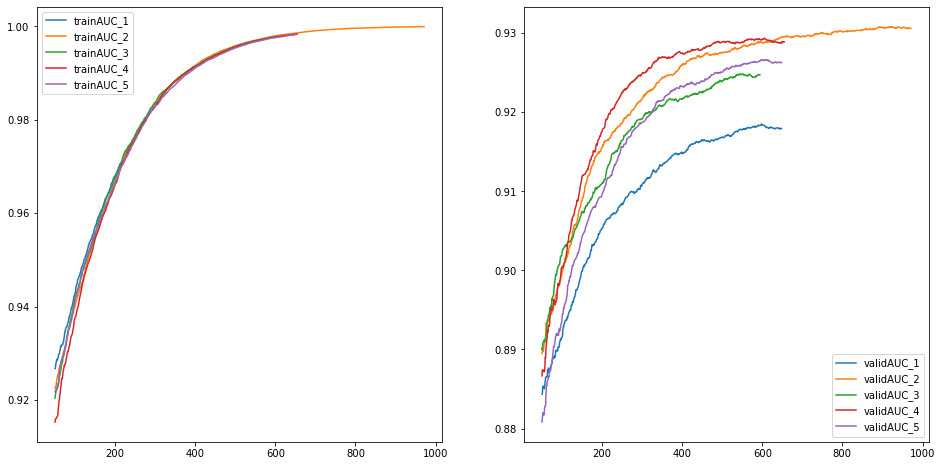

In [14]:
# Plot to compare results of each train and validation fold after using Cross Validation
fig, ax = plt.subplots(1, 2, figsize=(16,8))
for x in range(1, 6):
    hists[['trainAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[0])
    hists[['validAUC'+'_'+str(x)]].iloc[50:].plot(ax=ax[1])
plt.show()

19 0.9326597589305943
20 0.9330307559007067
21 0.9330814475581672
22 0.9332617308510356
23 0.9332684832994902
24 0.9328623218424033


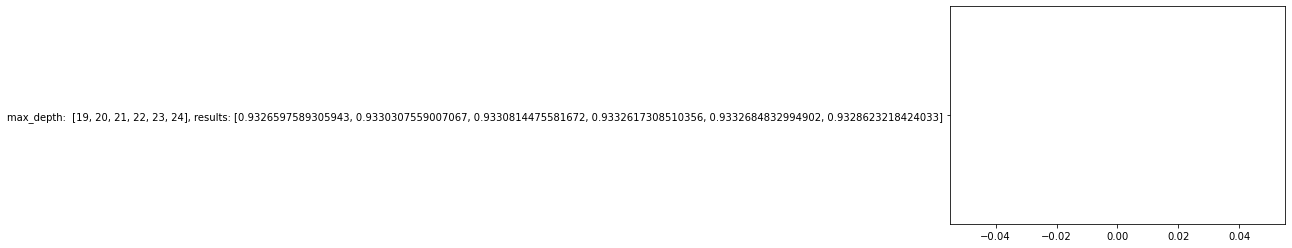

In [35]:
# Trying to find the best hyperparameters using Grid Search
rang = range(19,25)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True, max_depth=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

2 0.917760048552943
3 0.9226174383756136
4 0.9267803984610437
5 0.9296506808961553
6 0.9316355971539172
7 0.9332617308510356
8 0.9346881834065606
9 0.9354792630325551


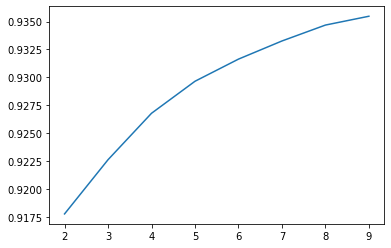

In [36]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=22, subsample = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

2 0.9313525175175672
3 0.9339277115487968
4 0.9353701765010494
5 0.9359784272469975
6 0.9349333648650869
7 0.9347080167292269
8 0.9342428748236715
9 0.9333429773385555


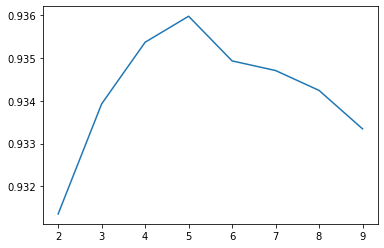

In [37]:
rang = range(2,10)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = x/10)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

In [ ]:
rang = range(0,8)
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = 0.5, lambdaX=x**2)
    print(x**2, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

In [39]:
rang = [0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 15]
results = []
for x in rang:
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=False, mlflow_tracking=True,
        max_depth=23, subsample = 0.8, colsample_bytree = 0.5, lambdaX=1, gamma=x)
    print(x, np.mean(testResults))
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

0.01 0.9356847168551689
0.1 0.9353868781633305
0.5 0.9346298607081603
1 0.9341392570807052


KeyboardInterrupt: 

eta 0.03, max_depth 24, subsample 0.9, colsample_bytree 0.5, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 31541
Length valid: 7886
[0]	train-auc:0.83950	valid-auc:0.77903
[1]	train-auc:0.91315	valid-auc:0.84091
[2]	train-auc:0.92335	valid-auc:0.84186
[3]	train-auc:0.94807	valid-auc:0.86393
[4]	train-auc:0.95510	valid-auc:0.86598
[5]	train-auc:0.95959	valid-auc:0.86917
[6]	train-auc:0.96286	valid-auc:0.88057
[7]	train-auc:0.96552	valid-auc:0.88261
[8]	train-auc:0.96834	valid-auc:0.88510
[9]	train-auc:0.97068	valid-auc:0.89069
[10]	train-auc:0.97164	valid-auc:0.89357
[11]	train-auc:0.97170	valid-auc:0.89282
[12]	train-auc:0.97244	valid-auc:0.89303
[13]	train-auc:0.97418	valid-auc:0.89344
[14]	train-auc:0.97747	valid-auc:0.89399
[15]	train-auc:0.97859	valid-

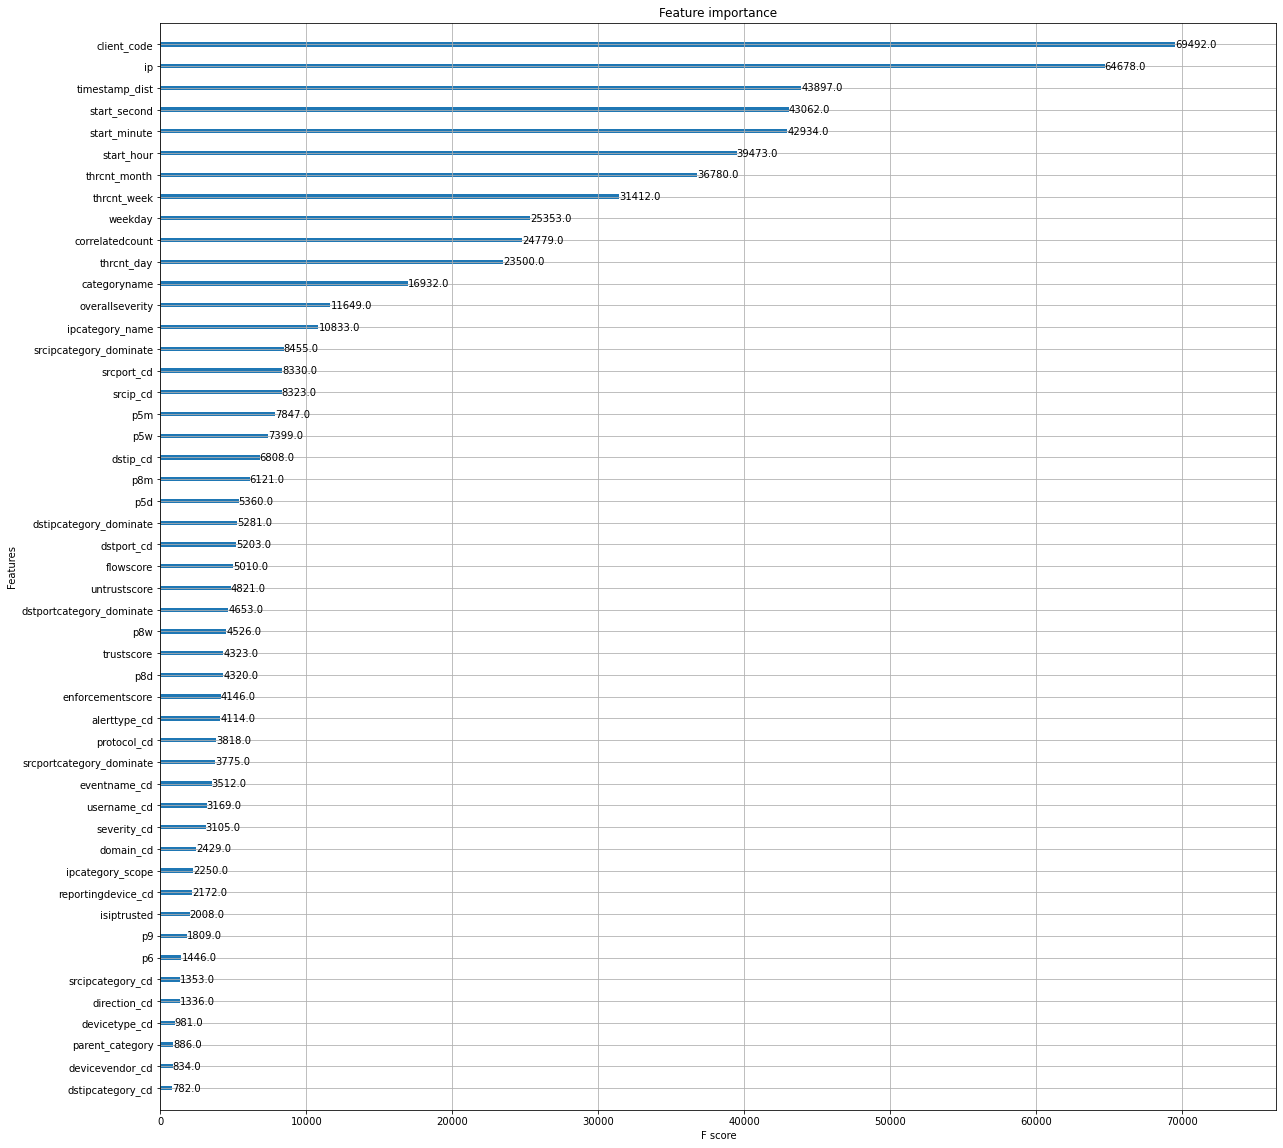

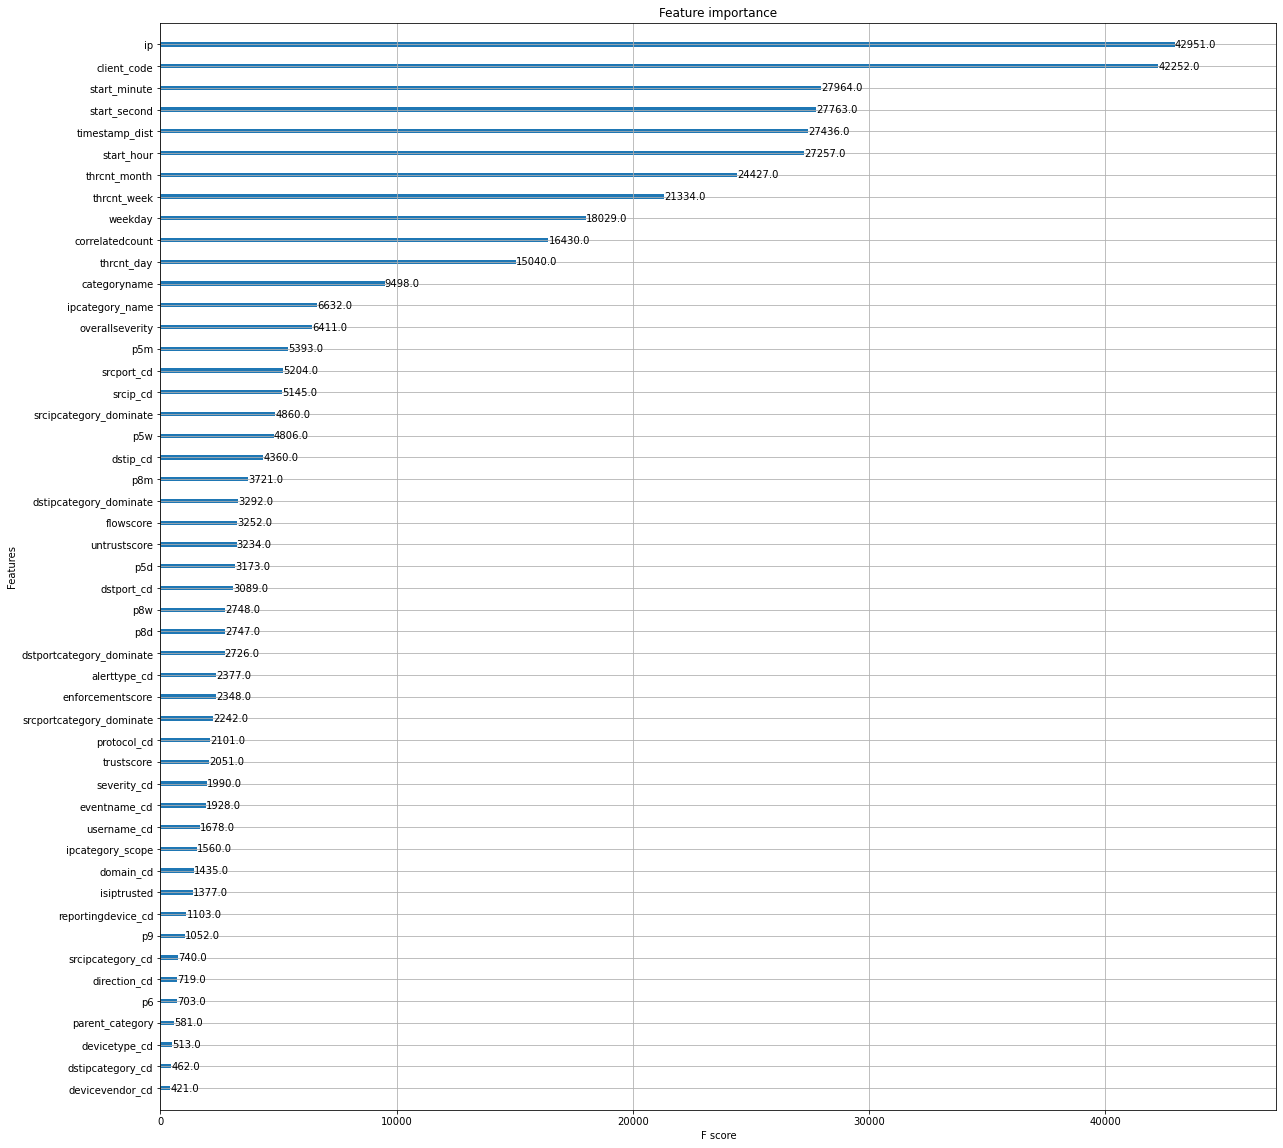

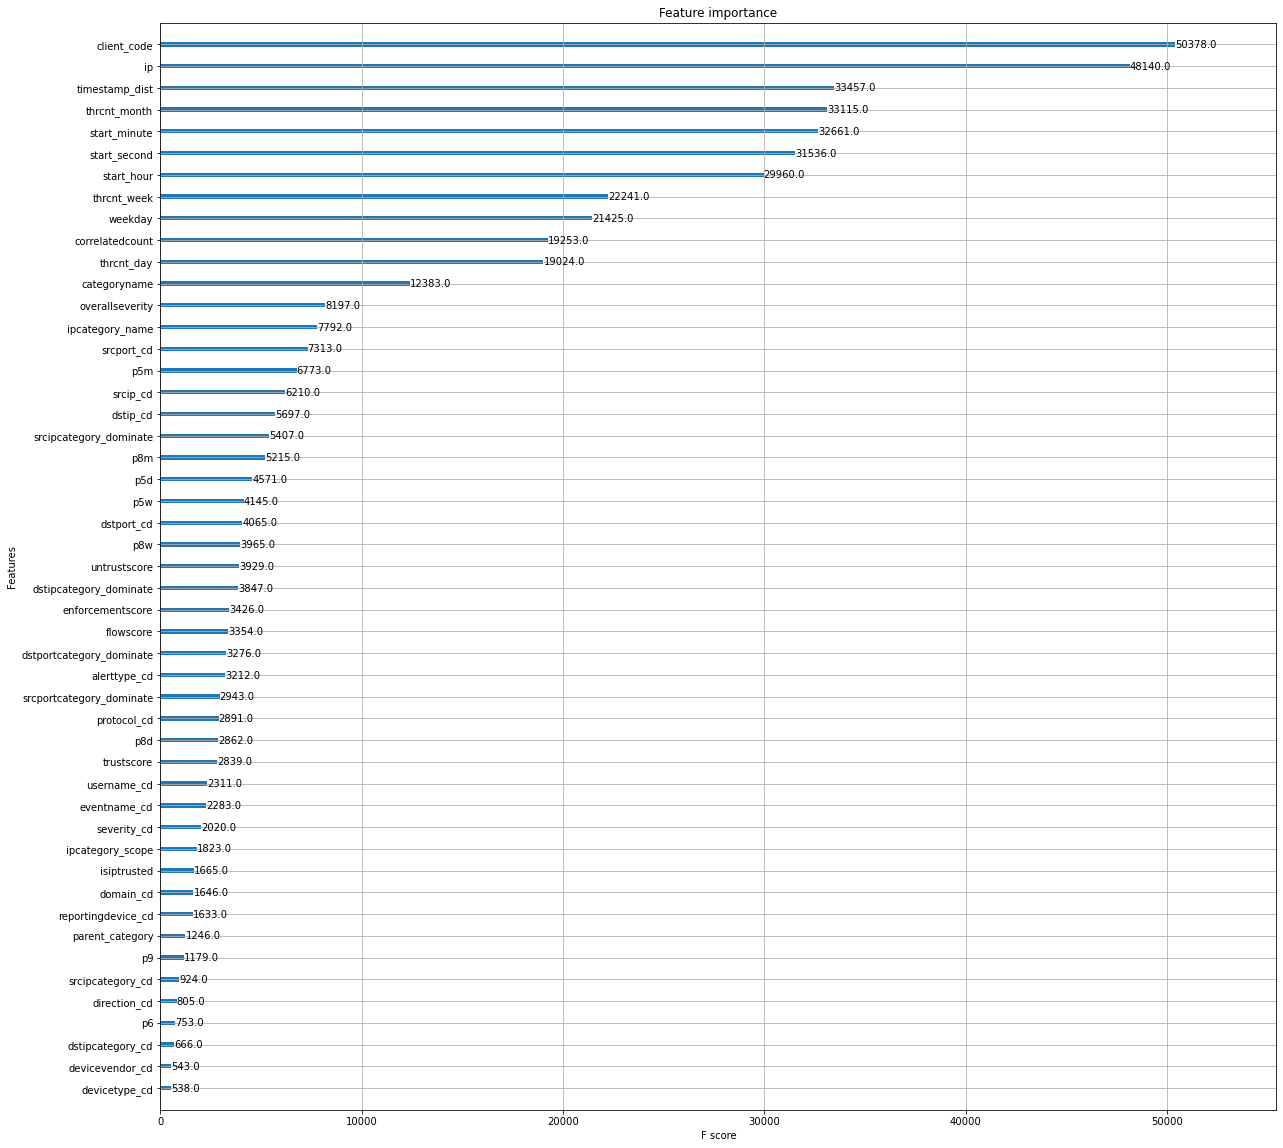

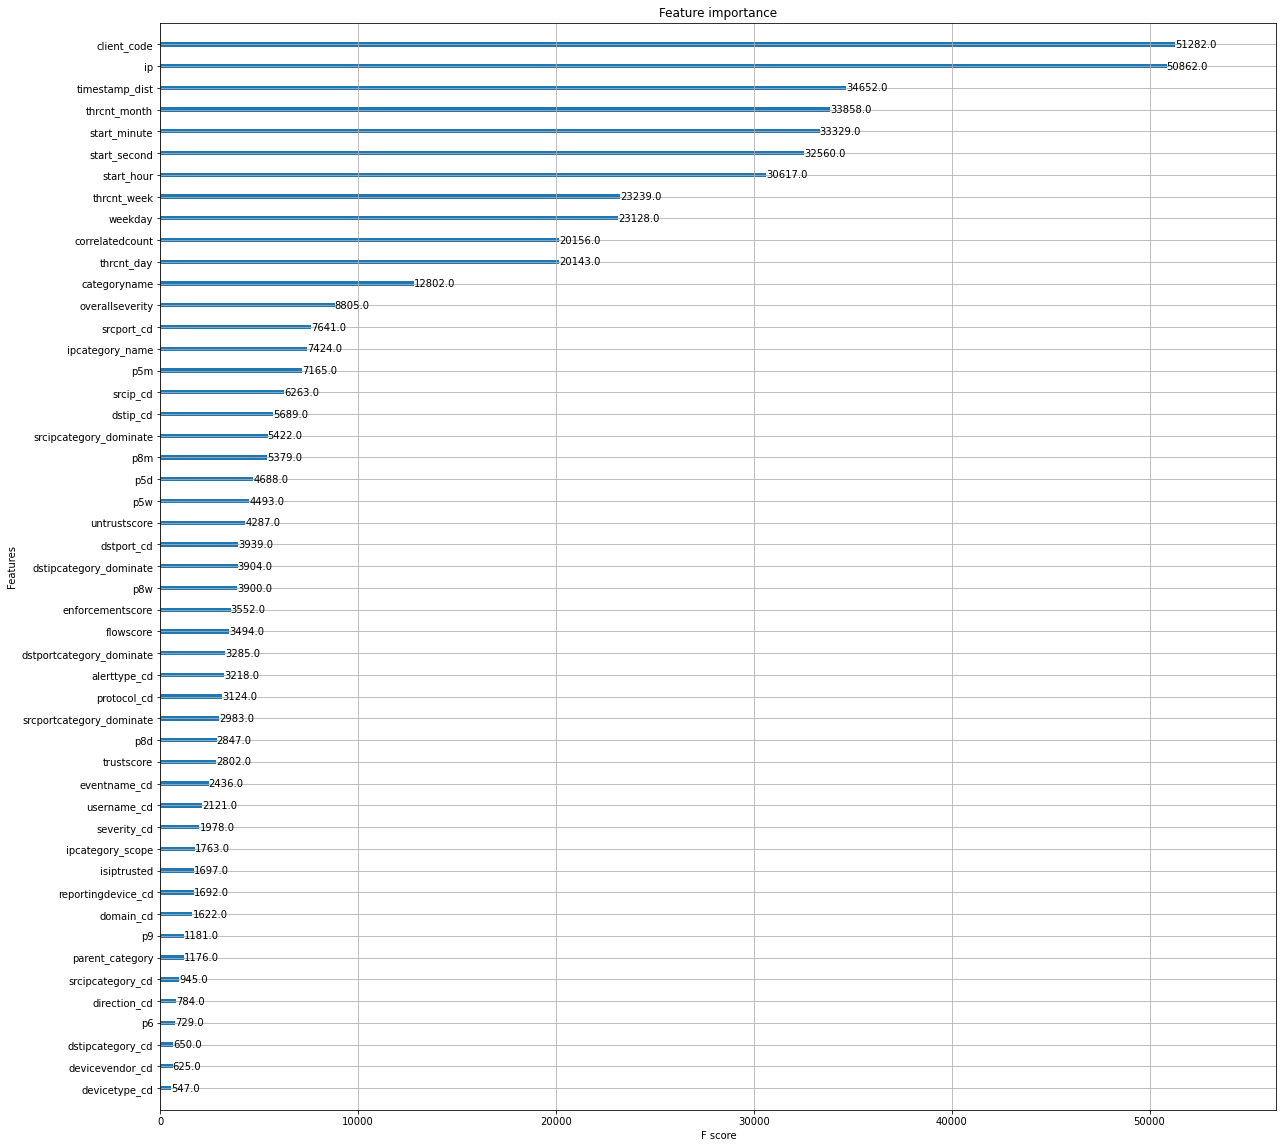

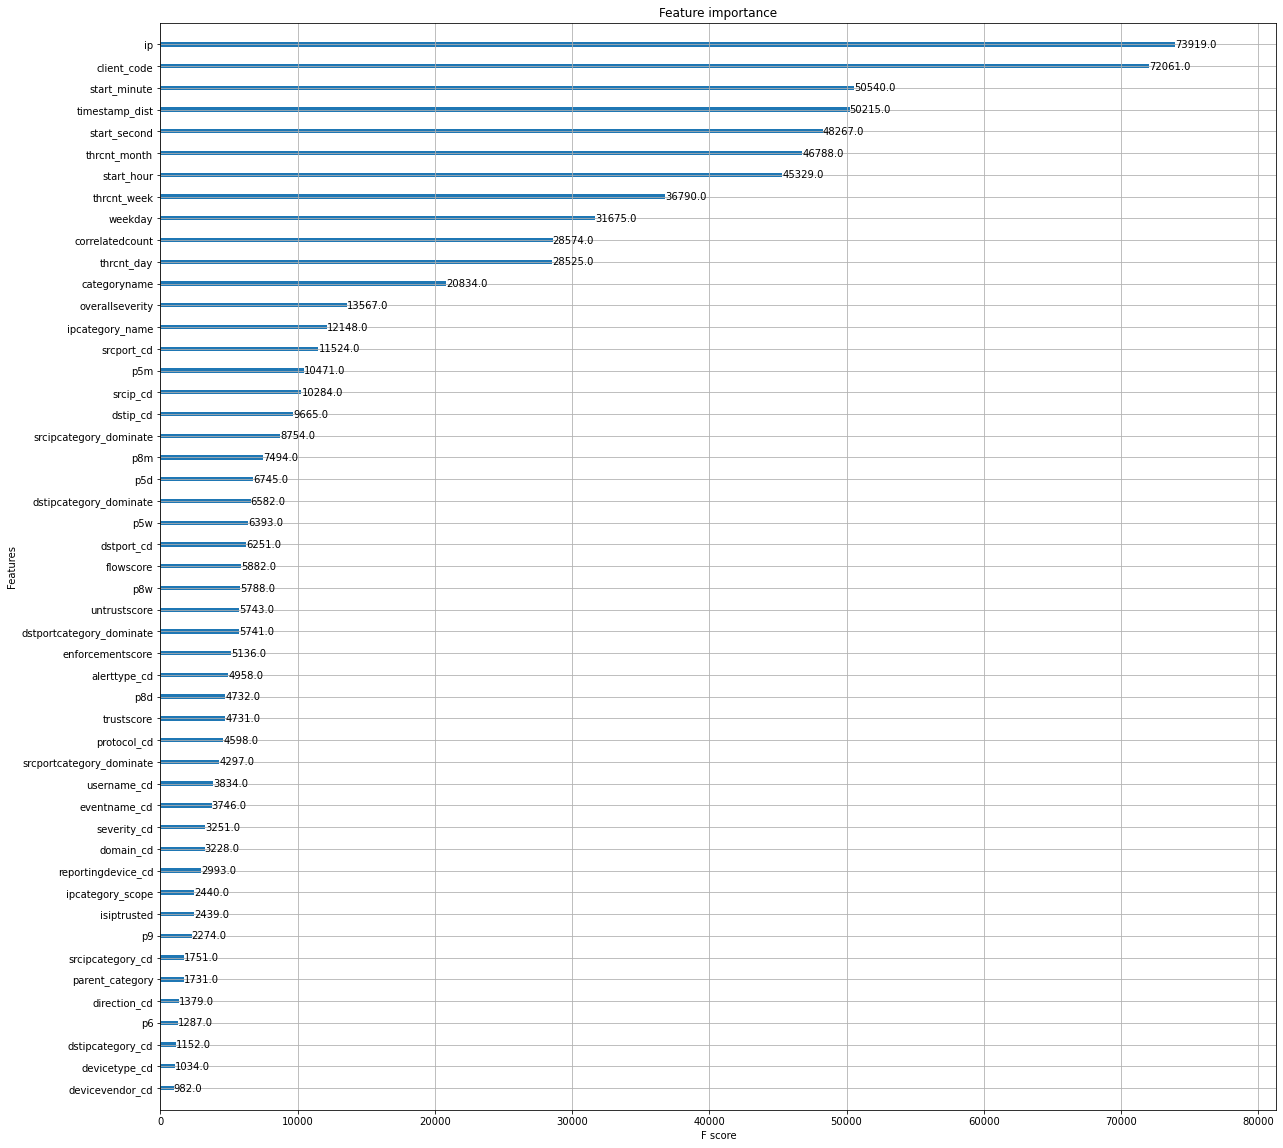

In [46]:
params = {
    'max_depth': 23,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'lambdaX': 1
}
trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features, debug=True, mlflow_tracking=True, exp_name="exp_3_XGBoost" , *params)
print(f'Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}')

In [ ]:
# Save results to file
modelXGB= {
    "name":"XGB-1",
    "description":"Model XGB, ze zmiennymi kategorycznymi",
    "specification": params,
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    'features':features
}
save_model_and_results('model_xgb_1', modelXGB)

## Random Search

In [ ]:
# Trying to find the best hyperparameters using Random Search
import random
results=[]
paramList = []
for x in range(90):
    params = (random.randint(15, 30), random.uniform(0.3, 0.9), random.uniform(0.3, 0.7), random.uniform(0.1, 10), random.uniform(0, 5))
    trainResults, testResults, predictions, indices, hists = cv_xgb(preprocessed_train_df, target, features,
                                                                    mlflow_tracking=True,
                                                                    exp_name="exp_4_XGBoost",
                                                                    max_depth = params[0],
                                                                    subsample = params[1],
                                                                    colsample_bytree = params[2],
                                                                    lambdaX=params[3]**2,
                                                                    gamma=params[4])
    print(np.mean(testResults), params)
    paramList.append(params)
    # Saving results
    results.append((np.mean(testResults), params.copy()))

    # Display results of current iteration
    print(params, np.mean(testResults))

    # Every 10 iterations display top 3 results from all iterations
    if x>1 and x%10==0:
        print("\n Top 3:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:3]:
            print(params, score)
        print()

In [ ]:
# Plot the top 10 higher-scoring experiments and their hyperparameters.
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

In [ ]:
# Plot to check how many iterations in RS we need to find better score and parameters
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

## Making prediction for competition

In [ ]:
params = {
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'lambdaX': 1,
    'max_depth':24,
    'early_stopping_rounds': 100
}
make_prediction_xgb(train_df=preprocessed_train_df, test_df=preprocessed_test_df, features=features, target=target, test_size = 0.1, file='results_5_xgb', **params)


eta 0.03, max_depth 24, subsample 0.9, colsample_bytree 0.5, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 100, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2022, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 35484
Length valid: 3943
[0]	train-auc:0.87088	valid-auc:0.82095
[1]	train-auc:0.91964	valid-auc:0.84885
[2]	train-auc:0.93790	valid-auc:0.86589
[3]	train-auc:0.94456	valid-auc:0.87548
[4]	train-auc:0.95141	valid-auc:0.87866
[5]	train-auc:0.95736	valid-auc:0.88443
[6]	train-auc:0.96545	valid-auc:0.88545
[7]	train-auc:0.96888	valid-auc:0.88794
[8]	train-auc:0.97156	valid-auc:0.89250
[9]	train-auc:0.97294	valid-auc:0.89210
[10]	train-auc:0.97233	valid-auc:0.89103
[11]	train-auc:0.97254	valid-auc:0.89258
[12]	train-auc:0.97478	valid-auc:0.89590
[13]	train-auc:0.97675	valid-auc:0.89720
[14]	train-auc:0.97846	valid-auc:0.89756
[15]	train-auc:0.97933	valid

## Comparing the results of different predictive models

In [9]:
with open("output/models/model_RF_1.p", "rb") as fp:
    model_RF_1 = pickle.load(fp)

# with open("output/models/model_RF_2.p", "rb") as fp:
#     model_RF_2 = pickle.load(fp)

with open("output/models/model_RF_3.p", "rb") as fp:
    model_RF_3 = pickle.load(fp)

with open("output/models/model_xgb_1.p", "rb") as fp:
    model_xgb_1 = pickle.load(fp)

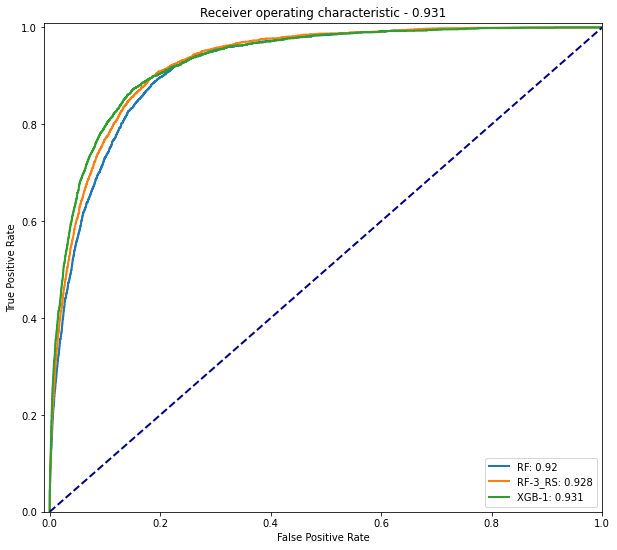

In [10]:
# Prepare data for the AUC-ROC curve
res2plot = []
true = preprocessed_train_df[target].sort_index()
for result in [model_RF_1, model_RF_3, model_xgb_1]:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

# Plot AUC-ROC curves
plot_roc_auc(res2plot)